<a href="https://colab.research.google.com/github/dbgks25/algorithm-study/blob/main/stock_predict/Nifty_50_Stock_Market_Data(2000_2021)_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow transformers

In [13]:
# Transformer 모델 정의
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
df = pd.read_csv('ADANIPORTS.csv')

# 필요한 열 선택 및 전처리
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.dropna()


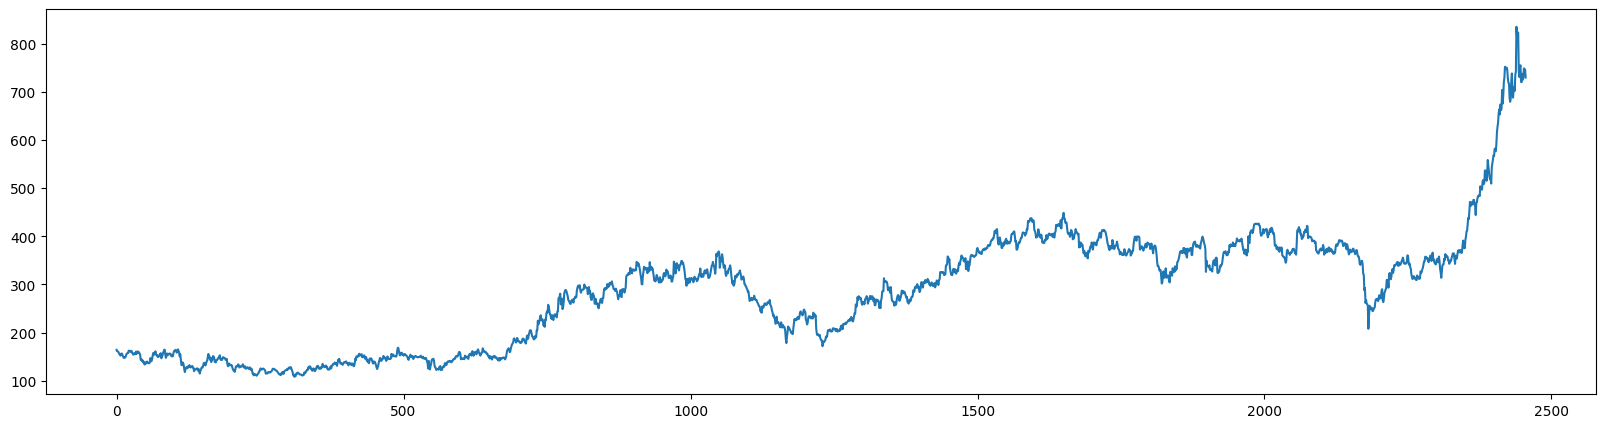

In [11]:
plt.figure(figsize=(20,5))
plt.plot(range(len(df)), df["Close"])

In [12]:
# 특성 선택 및 데이터셋 분할
X = df[['Close']].values
y = df['Close'].values

# 데이터 표준화
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

Epoch 1/50, Loss: 0.016360506415367126
Epoch 2/50, Loss: 0.019156161695718765
Epoch 3/50, Loss: 0.012981732375919819
Epoch 4/50, Loss: 0.015940522775053978
Epoch 5/50, Loss: 0.018941504880785942
Epoch 6/50, Loss: 0.017997989431023598
Epoch 7/50, Loss: 0.021456627175211906
Epoch 8/50, Loss: 0.00671571446582675
Epoch 9/50, Loss: 0.02794913575053215
Epoch 10/50, Loss: 0.02939387783408165
Epoch 11/50, Loss: 0.012219219468533993
Epoch 12/50, Loss: 0.014251014217734337
Epoch 13/50, Loss: 0.005051839165389538
Epoch 14/50, Loss: 0.012517278082668781
Epoch 15/50, Loss: 0.01400384958833456
Epoch 16/50, Loss: 0.004981207195669413
Epoch 17/50, Loss: 0.007619387470185757
Epoch 18/50, Loss: 0.005808186251670122
Epoch 19/50, Loss: 0.00388824800029397
Epoch 20/50, Loss: 0.01342254038900137
Epoch 21/50, Loss: 0.012832799926400185
Epoch 22/50, Loss: 0.010366914793848991
Epoch 23/50, Loss: 0.007101979572325945
Epoch 24/50, Loss: 0.016638264060020447
Epoch 25/50, Loss: 0.01696593686938286
Epoch 26/50, Los

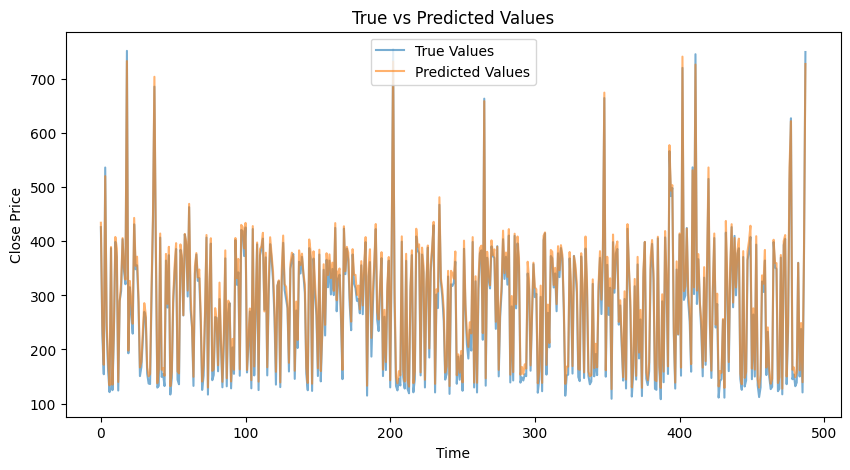

In [15]:
# 시퀀스 생성 함수
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
        # 시퀀스 형태의 x, y 출력
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 20
X_seq, y_seq = create_sequences(X, y, SEQ_LENGTH)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# PyTorch Tensor로 변환
# y_train, y_test를 2D 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader 생성
# DataLoader : 데이터를 배치로 로드할 수 있게 함
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transformer 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, num_heads, embed_dim, ff_dim, seq_length):
        super(TransformerModel, self).__init__()
        # embedding : 입력 차원을  embed_dim으로 변환
        # MultiheadAttention : Transformer의 핵심인 다중 헤드 어텐션 레이어
        # LayerNorm : 각 레이어의 출력을 정규화한다
        # Droupout : 과적합을 방지하기 위해 일부 뉴런을 무작위로 제외
        # Flatten : 2D -> 1D
        # Linear : 출력 차원을 1로 변환

        # 입력 차원을 임베딩 차언으로 변환
        # 왜 변환할까?
        self.embedding = nn.Linear(1, embed_dim)  # 입력 차원을 embed_dim으로 변환

        # 여러 개의 어텐션 헤드를 통해 입력 시퀀스 내에서 각 위치의 벡터를 다른 모든 위치의 벡터와 비교
        # MultiheadAttention : Transformer의 핵심인 다중 헤드 어텐션 레이어
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.1)

        # Feed-Forward Network(FFN)
        # 두 개의 선형 변환과 중간에 ReLU 활성화 함수 포함
        # FFN : Transformer의 핵심인 FFN 레이어
        # 이게 정확히 뭘까
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

        # LayerNorm : 각 레이어의 출력을 정규화한다 - 학습 안정화 + 학습 속도 향상
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)

        # Dropout : 과적합을 방지하기 위해 일부 뉴런을 무작위로 제외
        self.dropout = nn.Dropout(0.1)

        # Flatten : 2D -> 1D --- Dense 레이어에 입력할 수 있도록 함
        self.flatten = nn.Flatten()

        # 마지막 출력을 하나의 값으로 변환 - 최종 출력은 예측된 주식 가격
        self.dense = nn.Linear(embed_dim * seq_length, 1)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_length, 1) -> (batch_size, seq_length, embed_dim)
        x = x.permute(1, 0, 2)  # (batch_size, seq_length, embed_dim) -> (seq_length, batch_size, embed_dim)
        attn_output, _ = self.att(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.layernorm1(x)
        ffn_output = self.ffn(x)
        x = x + self.dropout(ffn_output)
        x = self.layernorm2(x)
        x = x.permute(1, 0, 2)  # (seq_length, batch_size, embed_dim) -> (batch_size, seq_length, embed_dim)
        x = self.flatten(x)
        return self.dense(x)

# 모델 인스턴스 생성
model = TransformerModel(num_heads=2, embed_dim=64, ff_dim=64, seq_length=SEQ_LENGTH)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    # 데이터 로드한 데이터 가지고 배치 학습
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward() # 역전파로 그라디언트 계산
        optimizer.step() # 옵티마이저를 통해 가중치 업데이트
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# 모델 평가
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).numpy()
    y_pred_test = model(X_test).numpy()

# 원래 값으로 되돌림
y_pred_train = scaler_y.inverse_transform(y_pred_train)
y_pred_test = scaler_y.inverse_transform(y_pred_test)
y_train = scaler_y.inverse_transform(y_train.numpy().reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Values', alpha=0.6)
plt.plot(y_pred_test, label='Predicted Values', alpha=0.6)
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

Test MSE: 201.58151245117188
Test MAE: 12.926509857177734
Test R²: 0.9859765928031632


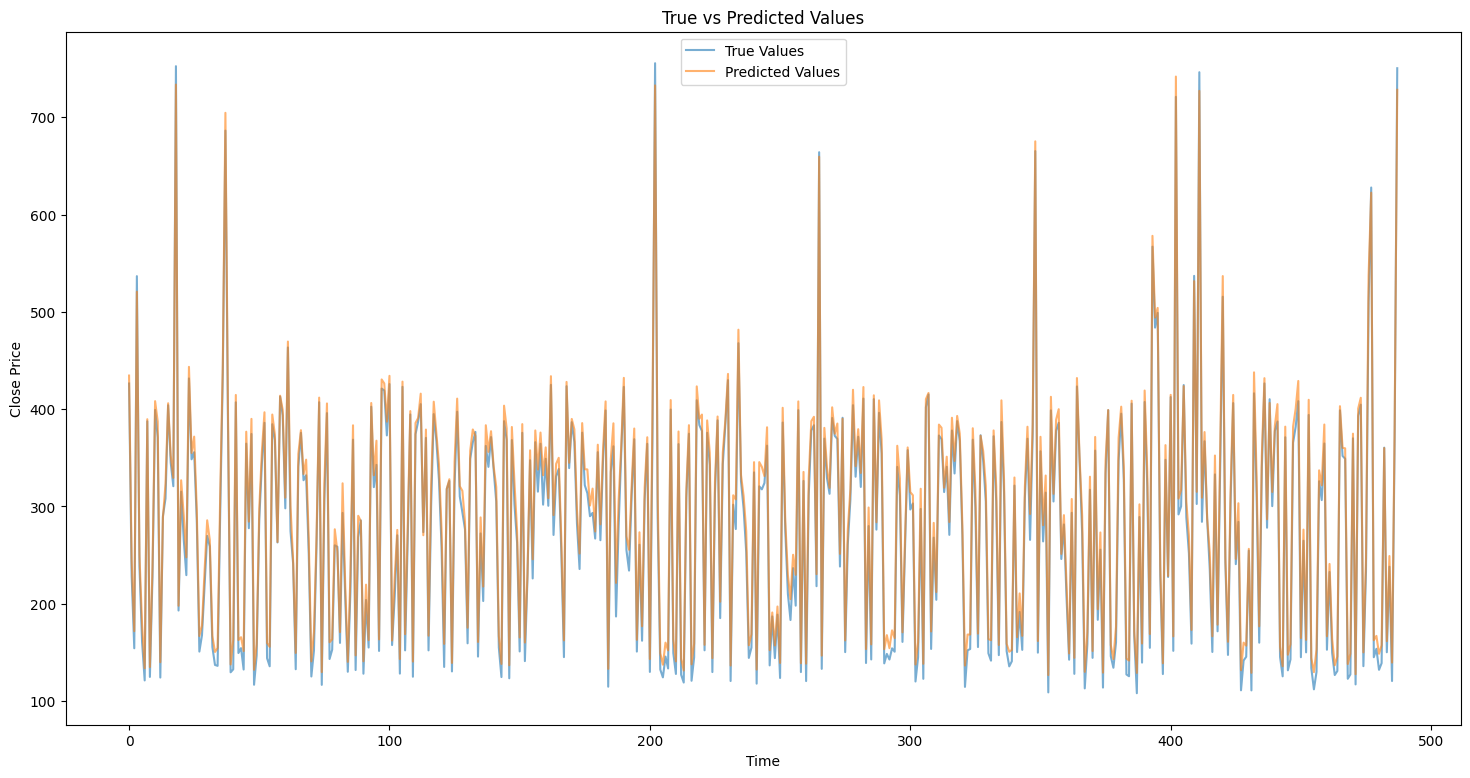

In [26]:
from sklearn.metrics import r2_score
# 평가 지표 계산
test_mse = np.mean((y_test - y_pred_test.flatten())**2)
test_mae = np.mean(np.abs(y_test - y_pred_test.flatten()))
test_r2 = r2_score(y_test, y_pred_test.flatten())

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test R²: {test_r2}")

# 예측 결과 시각화
plt.figure(figsize=(18, 9))
plt.plot(y_test, label='True Values', alpha=0.6)
plt.plot(y_pred_test, label='Predicted Values', alpha=0.6)
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Close Price')

# 인터랙티브 플롯 활성화
mplcursors.cursor(hover=True)

plt.show()

모델 구조 시각화

In [33]:
pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [34]:
from torch.utils.data import DataLoader, TensorDataset
from torchviz import make_dot

In [36]:

# 시각화를 위한 예제 입력 생성
example_input = torch.randn(1, SEQ_LENGTH, 1)
# 모델 시각화
y_pred_example = model(example_input)
dot = make_dot(y_pred_example, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('transformer_model_visualization')

'transformer_model_visualization.png'

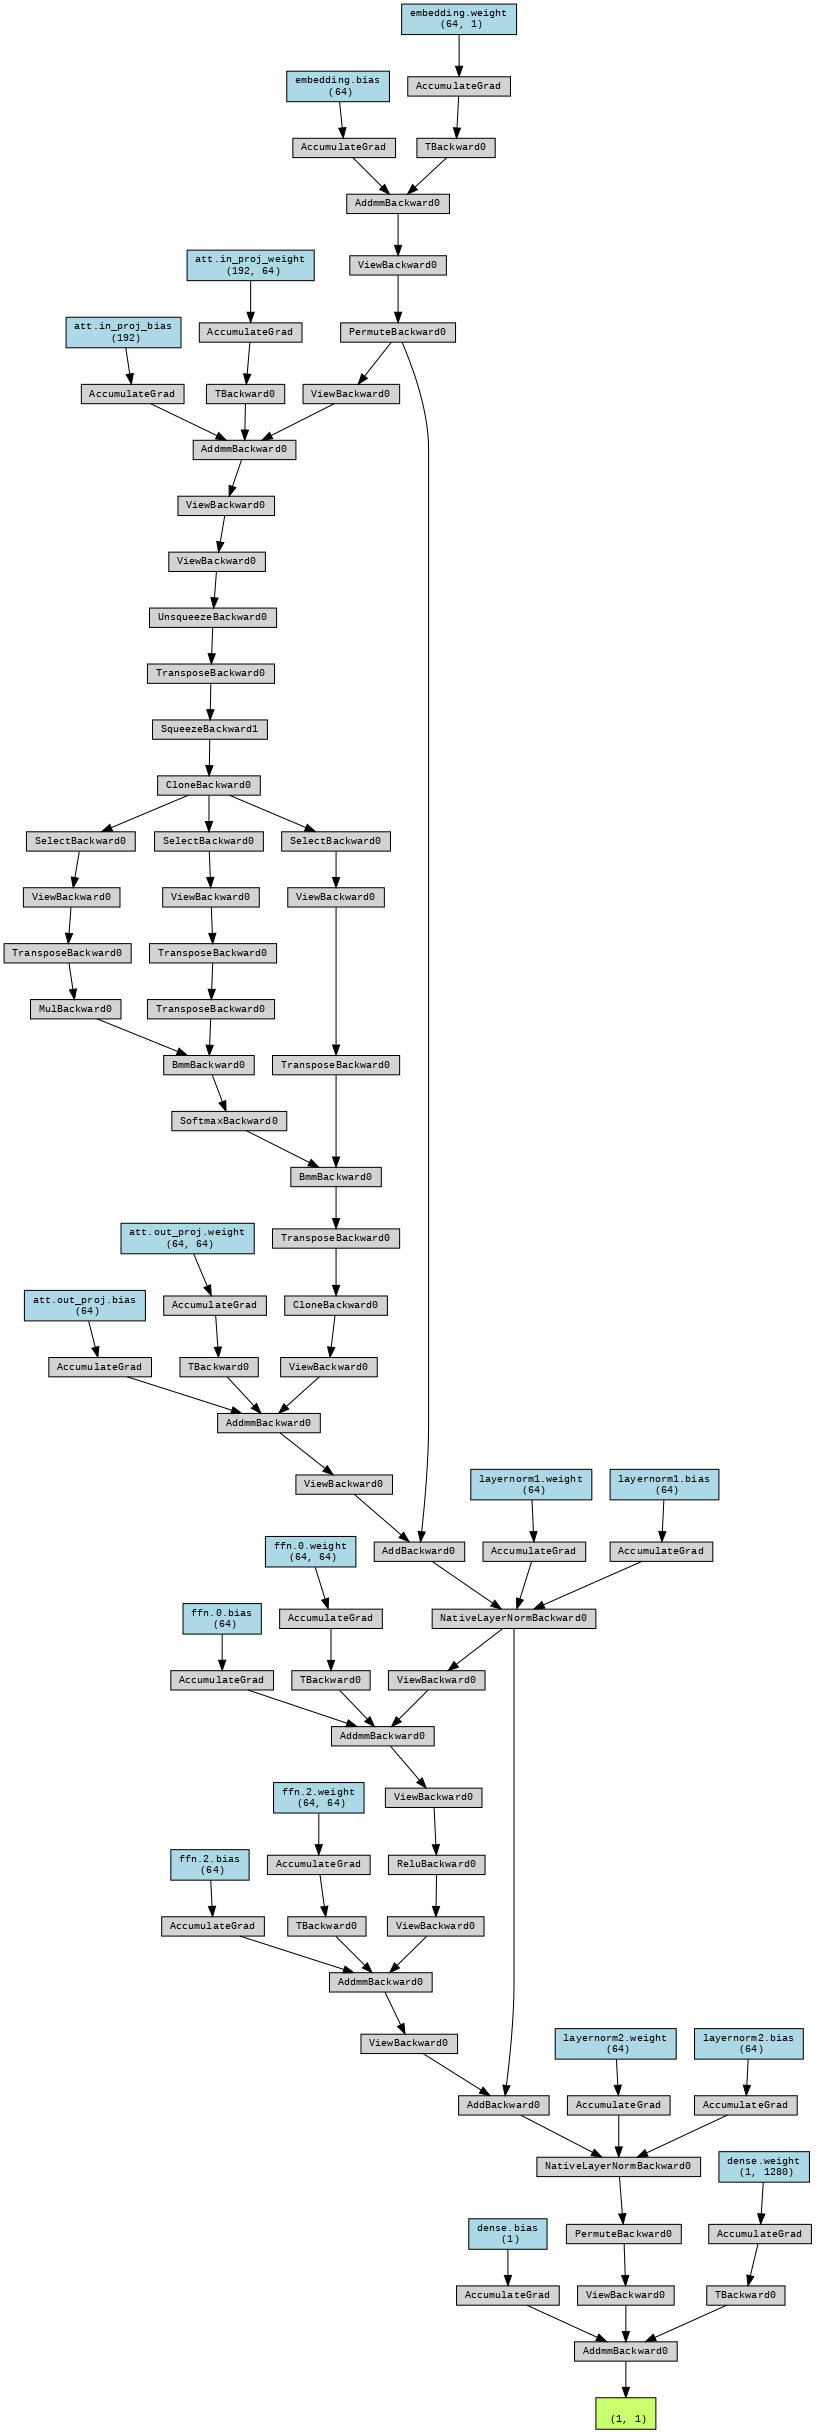

In [37]:

# 시각화 이미지 표시
from IPython.display import Image
Image(filename='transformer_model_visualization.png')

In [ ]:
# 비트코스 매매 알고리즘?!